# Выбор локации для скважины

Допустим, что добывающая компания «ГлавРосГосНефть» поставила задачу - решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.   

Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Также, нужно проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных  

Данные геологоразведки трёх регионов находятся в файлах:

/datasets/geo_data_0.csv   
/datasets/geo_data_1.csv    
/datasets/geo_data_2.csv   

id — уникальный идентификатор скважины;  
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
product — объём запасов в скважине (тыс. баррелей).  

# Условия выполнения задачи:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  

* Бюджет на разработку скважин в регионе — 10 млрд рублей.  

* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  

* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  

* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.  

In [1]:
# Импортируем инструменты, которые понадобятся нам для работы:

import pandas as pd

import math

import sklearn

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_squared_error

from numpy.random import RandomState
state = RandomState(12345)

from tqdm import tqdm

## Загрузка и подготовка данных

Загружаем полученные данные о трех регионах

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

Изучим информацию датафреймов по первым 5 строкам:

In [3]:
# Регион "0":

print(df_0.info())
df_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
# Регион "1":

print(df_1.info())
df_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
# Регион "2":

print(df_2.info())
df_2.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
# Проверим данные на наличие дубликатов:

print(' Количество дубликатов в df_0:', df_0.duplicated().sum(),
    '\n','Количество дубликатов в df_1:', df_1.duplicated().sum(),'\n','Количество дубликатов в df_2:', df_2.duplicated().sum())

 Количество дубликатов в df_0: 0 
 Количество дубликатов в df_1: 0 
 Количество дубликатов в df_2: 0


In [7]:
# Столбец 'ID' не информативен для модели, удалим его:

df_0 = df_0.drop('id', axis=1)
df_1 = df_1.drop('id', axis=1)
df_2 = df_2.drop('id', axis=1)

Мы увидели, что:  
* признаки масштабированы  
* дубликатов и пропусков нет  
* типы данных менять не нужно  
* удалим столбец id, так как для обучения моделей он нам не понадобится    


## Обучение и проверка модели

Приступим к обучению модели. Разбъем данные на обучающую и валидационную выборки в соотношении 75:25

In [8]:
#Регион "0"
# Разделим данные на features и target - целевой признак:

target_0 = df_0['product']
features_0 = df_0.drop('product', axis=1)

# Разделим данные на обучающую и валидационную выборку:

features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)

In [9]:
#Регион "1"
# Разделим данные на features и target - целевой признак:

target_1 = df_1['product']
features_1 = df_1.drop('product', axis=1)

# Разделим данные на обучающую и валидационную выборку:

features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

In [10]:
#Регион "2"
# Разделим данные на features и target - целевой признак:

target_2 = df_2['product']
features_2 = df_2.drop('product', axis=1)

# Разделим данные на обучающую и валидационную выборку:

features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

In [11]:
# Создадим модель линейной регрессии Региона "0":

model_LR_0 = LinearRegression().fit(features_0_train, target_0_train)

predictions_0 = model_LR_0.predict(features_0_valid)

print('Оценки фактического запаса сырья в месторождении региона "0" равны:')
print('R2:','{:.3f}'.format(r2_score(target_0_valid,predictions_0)))
print('MAE:','{:.3f}'.format(mean_absolute_error(target_0_valid,predictions_0)))
print('RMSE:','{:.3f}'.format(mean_squared_error(target_0_valid,predictions_0)**0.5))
print('Средний запас сырья:','{:.1f}'.format(target_0.mean()))

Оценки фактического запаса сырья в месторождении региона "0" равны:
R2: 0.280
MAE: 30.920
RMSE: 37.579
Средний запас сырья: 92.5


In [12]:
# Создадим модель линейной регрессии Региона "1":

model_LR_1 = LinearRegression().fit(features_1_train, target_1_train)

predictions_1 = model_LR_1.predict(features_1_valid)

print('Оценки фактического запаса сырья в месторождении региона "1" равны:')
print('R2:','{:.4f}'.format(r2_score(target_1_valid,predictions_1)))
print('MAE:','{:.3f}'.format(mean_absolute_error(target_1_valid,predictions_1)))
print('RMSE:','{:.3f}'.format(mean_squared_error(target_1_valid,predictions_1)**0.5))
print('Средний запас сырья:','{:.1f}'.format(target_1.mean()))

Оценки фактического запаса сырья в месторождении региона "1" равны:
R2: 0.9996
MAE: 0.719
RMSE: 0.893
Средний запас сырья: 68.8


In [13]:
# Создадим модель линейной регрессии Региона "2":

model_LR_2 = LinearRegression().fit(features_2_train, target_2_train)

predictions_2 = model_LR_2.predict(features_2_valid)

print('Оценки фактического запаса сырья в месторождении региона "2" равны:')
print('R2:','{:.4f}'.format(r2_score(target_2_valid,predictions_2)))
print('MAE:','{:.3f}'.format(mean_absolute_error(target_2_valid,predictions_2)))
print('RMSE:','{:.3f}'.format(mean_squared_error(target_2_valid,predictions_2)**0.5))
print('Средний запас сырья:','{:.1f}'.format(target_2.mean()))


Оценки фактического запаса сырья в месторождении региона "2" равны:
R2: 0.2052
MAE: 32.793
RMSE: 40.030
Средний запас сырья: 95.0


# Проанализируем результаты  

Проверим корреляцию признаков регионов



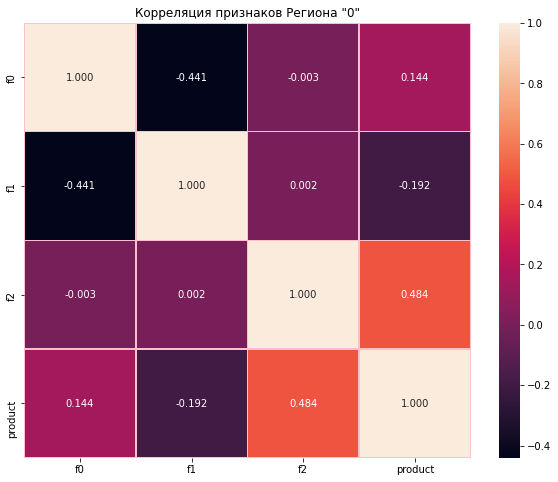

In [14]:
# Для этого создадим график:

plt.figure(figsize=(10,8))
sns.heatmap(df_0.loc[:, ['f0','f1','f2','product']].corr(), annot=True, fmt=".3f", linewidths=.5,linecolor='pink')
plt.title('Корреляция признаков Региона "0"')
plt.show()

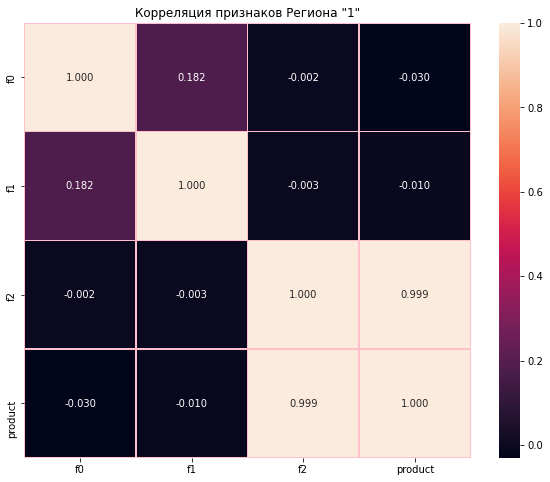

In [15]:
# Также проверим Регион "1":

plt.figure(figsize=(10,8))
sns.heatmap(df_1.loc[:, ['f0','f1','f2','product']].corr(), annot=True, fmt=".3f", linewidths=.5,linecolor='pink')
plt.title('Корреляция признаков Региона "1"')
plt.show()

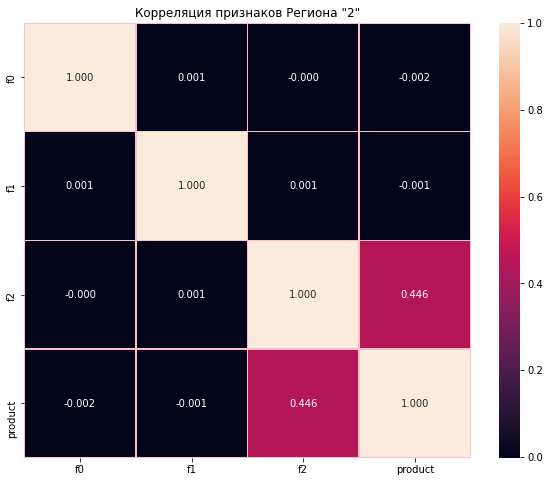

In [16]:
# Также проверим Регион "2":
plt.figure(figsize=(10,8))
sns.heatmap(df_2.loc[:, ['f0','f1','f2','product']].corr(), annot=True, fmt=".3f", linewidths=.5,linecolor='pink')
plt.title('Корреляция признаков Региона "2"')
plt.show()

# Вывод:  

* Регион "0": Ошибка в  регионе самая маленькая, но по среднему объему запасов регион отстает  
* Регион "1": Имеет худшие показатели из трех
* Регион "2": Имеет самый большой запас сырья, но по ошибкам уступает Региону "0"  

Также можно сделать вывод, что регионы "0" и "2" имеют похожую корреляцию признаков, а Регион "1" имеет корреляцию всех признаков

## Подготовка к расчёту прибыли

Напомню, что условия задачи таковы:

При разведке региона исследуют 500 точек - Min_points, из которых с помощью машинного обучения выбирают 200 лучших для разработки - Max_points.

Бюджет на разработку скважин в регионе — 10 млрд рублей - Budget.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей - Barrel.

In [17]:
# <эти значения были даны нам в условиях задачи>
BARREL = 450000
BUDGET = 10_000_000_000
MIN_POINTS = 500
MAX_POINTS = 200
THRESHOLD =  0.025

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. И сравним полученный объём сырья со средним запасом в каждом регионе.

In [18]:
min_size = BUDGET / MAX_POINTS / BARREL
print('Минимальное колличество баррелей:', round(min_size,2))


Минимальное колличество баррелей: 111.11


# Посмотрим распределение значений по районам

In [19]:
predictions_0 = pd.Series(predictions_0)

print('В Регионе "0", подходящих месторождений:', predictions_0[predictions_0 >= (min_size/1000)].count())

В Регионе "0", подходящих месторождений: 24999


In [20]:
predictions_1 = pd.Series(predictions_1)

print('В Регионе "1", подходящих месторождений:', predictions_1[predictions_1 >= (min_size/1000)].count())

В Регионе "1", подходящих месторождений: 24357


In [21]:
predictions_2 = pd.Series(predictions_2)

print('В Регионе "2", подходящих месторождений:',predictions_2[predictions_2 >= (min_size/1000)].count())

В Регионе "2", подходящих месторождений: 25000


Больше всего в Регионе "0" и в Регионе "2". 

# Напишем функцию для расчёта прибыли в полученных месторождениях и предсказания модели

In [24]:
def income(true_target, pred_target):
    sort_Series = pd.Series(pred_target).sort_values(ascending=False)[:MAX_POINTS]
    true_target_sort = (true_target
                         .reset_index(drop = True)[sort_Series.index])
    sum_true = true_target_sort.sum() 
    return round((sum_true * BARREL) - BUDGET,2)

In [25]:
print('Прибыль с лучших 200 скважин в Регионе "0":',income(target_0_valid,
                                                               predictions_0))
print('Прибыль с лучших 200 скважин в Регионе "1":',income(target_1_valid,
                                                               predictions_1))
print('Прибыль с лучших 200 скважин в Регионе "2":',income(target_2_valid,
                                                               predictions_2))

Прибыль с лучших 200 скважин в Регионе "0": 3320826043.14
Прибыль с лучших 200 скважин в Регионе "1": 2415086696.68
Прибыль с лучших 200 скважин в Регионе "2": 2710349963.6


# Вывод  

Минимальное количество баррелей нефти для безубыточной разработки составило 111.11

Распределение объема запасов по регионам проходит минимальный порог в 20%, проходит Регион "2" и почти Регион "0"

При этом расчет прибыли показал убыток на всех месторождениях

## Расчёт прибыли и рисков 

Теперь нужно выбрать сквжины в регионах с максимальными значениями предсказаний. Для этого используем технику Bootstrap

In [26]:
def bootstrap(true_target,pred_target):
    samples = []
    for i in tqdm(range(1000)):
        sample = pd.Series(pred_target).sample(n = MIN_POINTS, replace=True, random_state=state)
        samples.append(income(true_target,sample))
    samples = pd.Series(samples)
   
    print(samples.apply(lambda x: x < 0).sum()/len(samples)*100,"%")
    
    lower = samples.quantile(0.025)
    upper = samples.quantile(0.975)
    return round(lower,2), round(upper,2)

In [27]:
print('95% доверительный интервал для Региона "0" лежит между:',
      bootstrap(target_0_valid,pd.Series(predictions_0)))

print('95% Доверительный интервал для Региона "1" лежит между:',
      bootstrap(target_1_valid,predictions_1))

print('95% Доверительный интервал для Региона "2" лежит между:',
      bootstrap(target_2_valid,predictions_2))

100%|██████████| 1000/1000 [00:01<00:00, 902.43it/s]


6.9 %
95% доверительный интервал для Региона "0" лежит между: (-111215545.89, 909766941.55)


100%|██████████| 1000/1000 [00:00<00:00, 1003.01it/s]


0.7000000000000001 %
95% Доверительный интервал для Региона "1" лежит между: (78050810.75, 862952060.26)


100%|██████████| 1000/1000 [00:01<00:00, 958.86it/s]

6.5 %
95% Доверительный интервал для Региона "2" лежит между: (-112227625.38, 934562914.55)


## ОБЩИЙ ВЫВОД

Итого мы получили:  

# Регион "0"  

* Средний запас сырья: 92.5
* Подходящие месторождения: 24999
* Средняя прибыль: 3 320 826 043.14
* Границы доверительного интервала: -111 215 545.89, 909 766 941.55
* Риск убытков: 6.9 %


# Регион "1"

* Средний запас сырья: 68.8
* Подходящие месторождения: 24461
* Средняя прибыль: 2 415 086 696.68
* Границы доверительного интервала: 78 050 810.75, 86 2952 060.26
* Риск убытков: 0.7 %

# Регион "2"  

* Средний запас сырья: 95.0
* Подходящие месторождения: 25000
* Средняя прибыль: 2 710 349 963.6
* Границы доверительного интервала: -112 227 625.38, 934 562 914.55
* Риск убытков: 6.5 %

Учитывая полученные результаты, выбор очевиден - Регион "1", помимо самых низких показателей риска убытков стоит выбрать его и по причине самых узких границ доверительного интервала, что указывает на точность оценки.
